# Step 1: Importing dataset
The thermal "paper, rock, scissors" gesture dataset is available [here](https://drive.google.com/file/d/17eGKfERer8o2zrf8z1f2qs-Lk7xgZc19/view?usp=sharing). Download it ad extract with Linux system command `unzip`.

In [ ]:
!unzip /content/gesture_dataset.zip

# **Step 2: Loading dataset**

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split

Dataset contains at least 150 examples of each class (`paper`, `rock`, `scissors`, `other`). Used SqueezeNet architecture requires labels in a [one-hot encoding format](https://en.wikipedia.org/wiki/One-hot). Why to use this format you can learn from [Machine Learning Mastery blog post](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).

**The one-hot encoding format for a used dataset:**

|   Class  | Class ID | One-hot format |
|:--------:|:--------:|:--------------:|
|   other  |     0    |    [0,0,0,1]   |
| scissors |     1    |    [0,0,1,0]   |
|   rock   |     2    |    [0,1,0,0]   |
|   paper  |     3    |    [1,0,0,0]   |

In [ ]:
data = []
labels = []

for class_idx, class_dir in [([1,0,0,0], 'paper'), ([0,1,0,0], 'rock'), ([0,0,1,0], 'scissors'), ([0,0,0,1], 'other')]:
  for img_path in glob(f'/content/dataset/{class_dir}/*.jpg'):
    img = cv2.imread(img_path)
    data.append(img)
    labels.append(class_idx)

data = np.array(data)
labels = np.array(labels)

print(f'Data shape: {data.shape}\nLabels shape: {labels.shape}')

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16,4));

for i, (data_idx, data_label) in enumerate([(0, 'paper'), (152, 'rock'), (304, 'scissors'), (456, 'other')]):
  ax[i].imshow(data[data_idx]);
  ax[i].set_title(data_label);

Machine Learning datasets are usually split into 3 subsets: `train`, `validation`, and `test`. The training set is used for model training, validation isn't used directly for training but allows to check the improvement of the training process. The test set is only used for final model evaluation. A more comprehensive description is available in [the post on the Roboflow blog](https://blog.roboflow.com/train-test-split/).

Usually dataset is divided in ratio 70% - 15% - 15% for train, validation and test sets.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, train_size=0.8, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, train_size=0.5, shuffle=True)

print(f'Train data shape: {X_train.shape}\nValidation data shape: {X_val.shape}\nTest data shape: {X_test.shape}')

# **Step 3: Neural Network Model architecture**

For thermal gesture recognition, the [SqueezeNet](https://arxiv.org/abs/1602.07360) classification model will be used. It is a significantly smaller model than the ResNet family but allows achieving similar accuracy. Moreover, smaller architecture like SqueezeNet let to be used on edge devices like Raspberry Pi with an accelerator or NVIDIA Jetson family.

SqueezeNet architecture in form of layers blocks is depicted in the picture below.

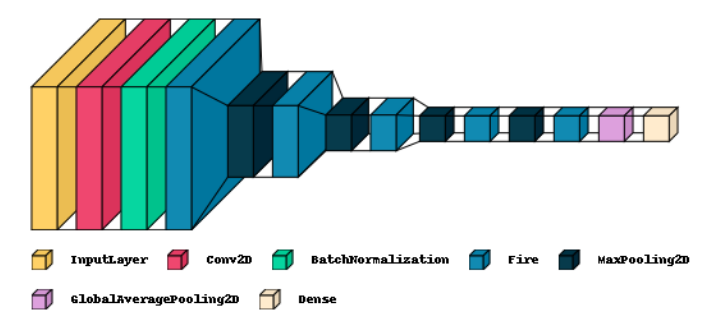

Part of architecture is a `Fire` layer which consists of parallel Convolution layers with 1x1 and 3x3 kernel sizes concatenated at the end of the module. Function `fire()` describes the architecture and the image below shows graphically the structure of the fire module.

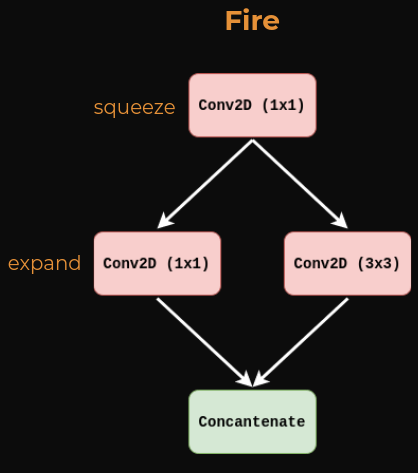

In [ ]:
def fire(x: tf.Tensor, squeeze: int, expand: int, bnmomemtum: float) -> tf.Tensor:
    y = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])


def fire_module(squeeze: int, expand: int, bnmomemtum: float) -> tf.Tensor:
    return lambda x: fire(x, squeeze, expand, bnmomemtum)

The basic training parameters are initialized below. The size of a single batch is set to 64, the number of training epochs is equal to 50, and the input shape equals (120, 160, 3). Moreover, the last layer (Dense layer) output consists of 4 nodes just like the number of classes in the dataset.

Model is compiled with optimizer Adam which is a good starting option. As a loss function (which will be optimized) [Categorical Cross-Entropy](https://machinelearningmastery.com/cross-entropy-for-machine-learning/) was chosen. Furthermore, 3 types of metrics are controlled during the training phase - [accuracy, precision, recall](https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/).

In order to stop training when there is no improvement, the [Early Stopping](https://en.wikipedia.org/wiki/Early_stopping) is utilized.

In [ ]:
batch_size = 64
nb_epoch = 50
img_rows, img_cols, channels = 120, 160, 3
classes = 4
bnmomemtum = 0.5

x = tf.keras.layers.Input(shape=[img_rows, img_cols, channels])

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48, bnmomemtum)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96, bnmomemtum)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128, bnmomemtum)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96, bnmomemtum)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48, bnmomemtum)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(classes, activation='softmax')(y)

model = tf.keras.Model(x, y)

model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau()
]

With the use of the `summary()` method one can check which layers (step by step) model contains their shape and the number of parameters.

In [ ]:
model.summary()

# **Step 4: Model training**

Train model with the use of training data and validation data for monitoring the progress.

In [ ]:
h = model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_val, y_val), callbacks=callbacks)

Models trained with the Tensorflow Keras framework return training history which can be visualized as below.

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16,4))

for i, label in enumerate(['loss', 'accuracy', 'precision_1', 'recall_1']):
  ax[i].plot(h.history[label], label=label)
  ax[i].plot(h.history[f'val_{label}'], label=f'val_{label}')
  ax[i].set_title(label)
  ax[i].legend()

# **Step 5: Model evaluation**

In this step, the trained model can be evaluated on a test set previously unseen by the algorithm.

In [ ]:
model.evaluate(X_test, y_test)

# **Step 6: Model saving**

In order to, use the trained model with thermal camera you have to save it in a SavedModel format with method `save` and compress directory with model using a Linux system command `zip` as follows:

In [ ]:
model.save('/content/squeezenet_gesture_recognition_model')